In [1]:
import torch
from torch import Tensor, nn
from math import ceil
from torch.autograd import Function
import os
from torch.autograd.function import Function
import triton
from copy import deepcopy
import triton.language as tl

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(DEVICE)

cuda


In [2]:
import math

def validate_contiguous(x: Tensor) -> Tensor:
    return x if x.is_contiguous() else x.contiguous()


def validate_tensor_device(x: Tensor):
    if not x.is_cuda:
        message = "Tensor must be on CUDA or TRITON_INTERPRET must be set to '1'"
        assert os.environ.get("TRITON_INTERPRET", False) == "1", message


def is_cuda_available() -> bool:
    return torch.cuda.is_available()


def get_device() -> torch.device:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    return torch.device(device)



@triton.jit
def _gelu_fwd_triton(
    x_ptr, tanh_ptr, phi_ptr, act_ptr, num_elements, block_size: tl.constexpr
):

    pid = tl.program_id(axis=0)
    ptr_offset = pid * block_size + tl.arange(0, block_size)

    mask = ptr_offset < num_elements

    x = tl.load(x_ptr + ptr_offset, mask)

    angle = tl.sqrt(2 / math.pi) * (x + 0.044715 * x * x * x)
    exp = tl.exp(2 * angle)
    tanh = (exp - 1) / (exp + 1)
    phi = 0.5 * (1 + tanh)
    chunk_act = x * phi

    tl.store(tanh_ptr + ptr_offset, tanh, mask)
    tl.store(phi_ptr + ptr_offset, phi, mask)
    tl.store(act_ptr + ptr_offset, chunk_act, mask)


def _gelu_fwd(x: Tensor, block_size: int = 2048) -> Tensor:
    validate_tensor_device(x)

    num_elements = x.numel()
    grid = (ceil(num_elements / block_size),)
    act = torch.empty_like(x).to(x.device)
    phi = torch.empty_like(x).to(x.device)
    tanh = torch.empty_like(x).to(x.device)

    _gelu_fwd_triton[grid](x, tanh, phi, act, num_elements, block_size)
    return act, tanh, phi


@triton.jit
def _gelu_bwd_triton(
    x_ptr, tanh_ptr, phi_ptr, derivative_ptr, num_elements, block_size: tl.constexpr
):

    pid = tl.program_id(axis=0)
    ptr_offset = pid * block_size + tl.arange(0, block_size)
    mask = ptr_offset < num_elements

    x = tl.load(x_ptr + ptr_offset, mask)
    tanh = tl.load(tanh_ptr + ptr_offset, mask)
    phi = tl.load(phi_ptr + ptr_offset, mask)

    factor = 1 / tl.sqrt(2 * math.pi)
    # angle = tl.sqrt(2 / pi) * (x + 0.044715 * x ** 3)
    # tanh = nn.functional.tanh(gx)
    phi_prime = factor * (1 - tanh * tanh) * (1 + 3 * 0.044715 * x * x)

    # phi = 0.5 * (1 + tanh)

    derivative = x * phi_prime + phi

    tl.store(derivative_ptr + ptr_offset, derivative, mask)


def _gelu_bwd(x: Tensor, tanh: Tensor, phi: Tensor, block_size: int = 2048) -> Tensor:
    for t in [x, tanh, phi]:
        validate_tensor_device(t)

    num_elements = x.numel()
    grid = (ceil(num_elements / block_size),)

    derivative = torch.empty_like(x).to(x.device)

    _gelu_bwd_triton[grid](x, tanh, phi, derivative, num_elements, block_size)

    return derivative


class GeluFunction(Function):
    @staticmethod
    def forward(ctx, x: Tensor):
        act, tanh, phi = _gelu_fwd(x)
        ctx.save_for_backward(x, tanh, phi)
        # return _gelu(x)
        return act

    @staticmethod
    def backward(ctx, grad_output):
        x, tanh, phi = ctx.saved_tensors

        # factor = 1 / (2 * math.pi) ** 0.5
        # gx = (2 / math.pi) ** 0.5 * (x + 0.044715 * x ** 3)
        # tanh = nn.functional.tanh(gx)
        # phi_prime = factor * (1 - tanh**2) * (1 + 3 * 0.044715 * x ** 2)
        # phi = 0.5 * (1 + tanh)

        # derivative = phi + x * phi_prime
        derivative = _gelu_bwd(x, tanh, phi)
        return derivative * grad_output


class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor) -> Tensor:
        if x.ndim > 1:
            x = validate_contiguous(x)
            return GeluFunction.apply(x.view(-1)).view(x.shape)
        return GeluFunction.apply(x)



In [3]:



@triton.jit
def _compute_tanh_phi(x):
    angle = tl.sqrt(2 / math.pi) * (x + .044715 * x * x * x)
    exp = tl.exp(2 * angle)
    tanh = (exp - 1) / (exp + 1)
    phi = 0.5 * (1 + tanh)
    return tanh, phi

@triton.jit
def _gelu_fwd_triton(
    x_ptr, act_ptr, num_elements, block_size: tl.constexpr
):

    pid = tl.program_id(axis=0)
    ptr_offset = pid * block_size + tl.arange(0, block_size)
    mask = ptr_offset < num_elements
    x = tl.load(x_ptr + ptr_offset, mask)

    _, phi = _compute_tanh_phi(x)
    chunk_act = x * phi

    tl.store(act_ptr + ptr_offset, chunk_act, mask)


def _gelu_fwd(x: Tensor, block_size: int = 2048) -> Tensor:
    validate_tensor_device(x)

    num_elements = x.numel()
    grid = (ceil(num_elements / block_size),)
    act = torch.empty_like(x).to(x.device)

    _gelu_fwd_triton[grid](x, act, num_elements, block_size)
    return act #, tanh, phi


@triton.jit
def _gelu_bwd_triton(
    x_ptr, grad_input_ptr, grad_output_ptr, num_elements, block_size: tl.constexpr
):

    pid = tl.program_id(axis=0)
    ptr_offset = pid * block_size + tl.arange(0, block_size)
    mask = ptr_offset < num_elements

    x = tl.load(x_ptr + ptr_offset, mask)
    grad_output = tl.load(grad_output_ptr + ptr_offset, mask)

    tanh, phi = _compute_tanh_phi(x)

    factor = 1 / tl.sqrt(2 * math.pi)
    phi_prime = factor * (1 - tanh * tanh) * (1 + 3 * 0.044715 * x * x)

    derivative = x * phi_prime + phi
    grad_input = derivative * grad_output

    tl.store(grad_input_ptr + ptr_offset, grad_input, mask)


def _gelu_bwd(x: Tensor, grad_output: Tensor, block_size: int = 2048) -> Tensor:
    # for t in [x, tanh, phi]:
    validate_tensor_device(x)

    num_elements = x.numel()
    grid = (ceil(num_elements / block_size),)

    grad_input = torch.empty_like(x).to(x.device)

    _gelu_bwd_triton[grid](x, grad_input, grad_output, num_elements, block_size)

    return grad_input


class GeluFunction(Function):
    @staticmethod
    def forward(ctx, x: Tensor):
        act = _gelu_fwd(x)
        ctx.save_for_backward(x)
        # return _gelu(x)
        return act

    @staticmethod
    def backward(ctx, grad_output):
        x,  = ctx.saved_tensors

        # factor = 1 / (2 * math.pi) ** 0.5
        # gx = (2 / math.pi) ** 0.5 * (x + 0.044715 * x ** 3)
        # tanh = nn.functional.tanh(gx)
        # phi_prime = factor * (1 - tanh**2) * (1 + 3 * 0.044715 * x ** 2)
        # phi = 0.5 * (1 + tanh)

        # derivative = phi + x * phi_prime
        grad_input = _gelu_bwd(x, grad_output)
        return grad_input


class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor) -> Tensor:
        if x.ndim > 1:
            x = validate_contiguous(x)
            return GeluFunction.apply(x.view(-1)).view(x.shape)
        return GeluFunction.apply(x)


AcceleratorError: CUDA error: an illegal memory access was encountered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


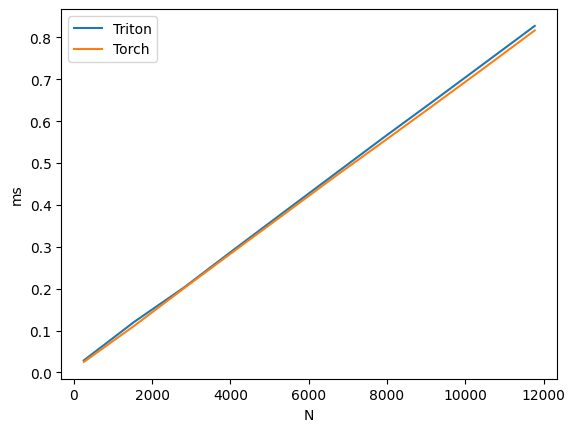

In [5]:
def measure_memory(f, *args, **kwargs):
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.empty_cache()

    f(*args, **kwargs)  # run your function once

    torch.cuda.synchronize()
    peak = torch.cuda.max_memory_allocated() / 1e6  # MB
    return peak

def benchmark_kernel(fwd, base_benchmark_kwargs):

    def bwd(x, provider):
        x.requires_grad = True
        out = fwd(x, provider)
        loss = out.sum()
        loss.backward()


    MAP_FWD_BKW = {
        "fwd" : fwd,
        "bwd" : bwd,
    }

    configs = []
    for bench_kind in ['timing', 'memory']:
        for mode in ['fwd', 'bwd']:
            _kwargs = deepcopy(base_benchmark_kwargs)
            _kwargs['args'].update({"mode" : mode})
            _kwargs['args'].update({"bench_kind" : bench_kind})
            _kwargs['ylabel'] = 'ms' if bench_kind == 'timing' else 'MB'
            _kwargs['plot_name'] += f' - {bench_kind} - {mode}'
            configs.append(triton.testing.Benchmark(**_kwargs))

    @triton.testing.perf_report(configs)
    def benchmark(M, N, provider, mode, bench_kind):
        print(f"Running benchmark: {mode=}, {bench_kind=}")
        x = torch.randn(M, N, device=DEVICE, dtype=torch.bfloat16)
        stream = getattr(torch, DEVICE.type).Stream()
        getattr(torch, DEVICE.type).set_stream(stream)
        if bench_kind == "timing":
            ms = triton.testing.do_bench(lambda: MAP_FWD_BKW[mode](x, provider))
            # gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
            return ms #gbps(ms)
        elif bench_kind == "memory":
            mem_mb = measure_memory(MAP_FWD_BKW[mode], x, provider)
            return mem_mb
        raise ValueError(f"bench_kind must be either 'timing' or 'memory', got {bench_kind}")

    result_dfs = benchmark.run(show_plots=False, print_data=False, return_df=True)
    for df, config in zip(result_dfs, configs):
        df.plot(x='N', ylabel = config.ylabel, title=config.plot_name, legend=True)

    return result_dfs

result_dfs = benchmark_kernel(fwd, base_benchmark_kwargs)

In [4]:
base_benchmark_kwargs = {
    "x_names":['N'],  # argument names to use as an x-axis for the plot
    "x_vals":[128 * i for i in range(2, 100, 10)],  # different possible values for `x_name`
    "line_arg":'provider',  # argument name whose value corresponds to a different line in the plot
    "line_vals":['triton', 'torch'],  # possible values for `line_arg``
    "line_names":["Triton", "Torch"],  # label name for the lines
    "plot_name":"gelu",  # name for the plot. Used also as a file name for saving the plot.
    "args":{'M': 4096} # values for function arguments not in `x_names` and `y_name`
}

_fwd = GELU()

def fwd(x, provider):
    ### for benchmark olny!
    if provider == "torch":
        return torch.nn.functional.gelu(x)
    elif provider == 'triton':
        return _fwd(x)
    else:
        raise ValueError


In [46]:
def measure_memory(f, *args, **kwargs):
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.empty_cache()

    f(*args, **kwargs)  # run your function once

    torch.cuda.synchronize()
    peak = torch.cuda.max_memory_allocated() / 1e6  # MB
    return peak

def benchmark_kernel(fwd, base_benchmark_kwargs):

    def bwd(x, provider):
        x.requires_grad = True
        out = fwd(x, provider)
        loss = out.sum()
        loss.backward()


    MAP_FWD_BKW = {
        "fwd" : fwd,
        "bwd" : bwd,
    }

    configs = []
    for bench_kind in ['timing', 'memory']:
        for mode in ['fwd', 'bwd']:
            _kwargs = deepcopy(base_benchmark_kwargs)
            _kwargs['args'].update({"mode" : mode})
            _kwargs['args'].update({"bench_kind" : bench_kind})
            _kwargs['ylabel'] = 'ms' if bench_kind == 'timing' else 'MB'
            _kwargs['plot_name'] += f' - {bench_kind} - {mode}'
            configs.append(triton.testing.Benchmark(**_kwargs))

    @triton.testing.perf_report(configs)
    def benchmark(M, N, provider, mode, bench_kind):
        x = torch.randn(M, N, device=DEVICE, dtype=torch.bfloat16)
        stream = getattr(torch, DEVICE.type).Stream()
        getattr(torch, DEVICE.type).set_stream(stream)
        if bench_kind == "timing":
            ms = triton.testing.do_bench(lambda: MAP_FWD_BKW[mode](x, provider))
            # gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
            return ms #gbps(ms)
        elif bench_kind == "memory":
            mem_mb = measure_memory(MAP_FWD_BKW[mode], x, provider)
            return mem_mb
        raise ValueError(f"bench_kind must be either 'timing' or 'memory', got {bench_kind}")

    result_dfs = benchmark.run(show_plots=False, print_data=False, return_df=True)
    for df, config in zip(result_dfs, configs):
        df.plot(x='N', ylabel = config.ylabel, title=config.plot_name, legend=True)

    return result_dfs

result_dfs = benchmark_kernel(fwd, base_benchmark_kwargs)

AcceleratorError: CUDA error: an illegal memory access was encountered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
